# Readme

In this file, cross-validation is applied to all the static neural networks: 'static nn 1', 'static nn 2', ..., 'static nn 12'.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from static_nn_module import RegressionNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data

## Data no embeddings

In [5]:
data_no_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_static_nn_1.csv")

In [6]:
data_no_embeddings = data_no_embeddings.drop(['Unnamed: 0'], axis = 1)

In [7]:
data_no_embeddings.shape

(699, 37)

In [8]:
data_no_embeddings.head (2)

,e.cum,e.rel,pmid,meas.tech,country,inst,ct,tan.app,app.rate,man.dm,man.ph,man.source,t.incorp,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,wind.2m_1,wind.2m_2,wind.2m_3,wind.2m_4,wind.2m_5,wind.2m_6,rain.rate_1,rain.rate_2,rain.rate_3,rain.rate_4,rain.rate_5,rain.rate_6,app.mthd_bc,app.mthd_bsth,app.mthd_ts,app.mthd_os,incorp_none,incorp_shallow
0,16.4190,0.134461,182,micro met,DK,104,164.99,122.11,31.8,3.7,7.35,0,1000.0,8.20,7.648529,6.766176,5.883824,5.001471,9.389090,8.10,7.494118,6.524706,5.555294,4.585882,5.340230,0.0,0.0,0.0,0.0,0.0,0.047679,1,0,0,0,1,0
1,6.9332,0.118882,183,micro met,DK,104,163.20,58.32,21.6,2.8,7.71,0,1000.0,13.77,13.568793,12.562759,11.489655,10.416552,10.006593,4.31,4.261897,4.021379,3.764828,3.508276,4.141415,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,0,1,0


## Data embeddings

In [9]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_static_nn_2.csv")

In [10]:
data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

## Test samples

In [11]:
with open("../00_data_preparation/processed_data/list_train_pmids.json", "r") as f:
    list_train_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_eval_pmids.json", "r") as f:
    list_eval_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_test_pmids.json", "r") as f:
    list_test_pmids = json.load(f)

# Models

| Numéro de modèle  | Architecture | embeddings |
| :--------------- |:---------------| :-----|
|1 | (26, 16) relu (16, 1) | non |
|2 | (26, 32) relu (32, 16) relu (16, 1) | non |
|3 | (26, 64) relu (64, 32) relu (32, 16) relu (16, 1) | non |
|4 | (26, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | non |
|5 | (26, 256) relu (256, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | non |
|6 | (26, 512) relu (512, 256) relu (256, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | non |
|7 | (26, 16) relu (16, 1) | oui |
|8 | (26, 32) relu (32, 16) relu (16, 1) | oui |
|9 | (26, 64) relu (64, 32) relu (32, 16) relu (16, 1) | oui |
|10 | (26, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | oui |
|11| (26, 256) relu (256, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | oui |
|12| (26, 512) relu (512, 256) relu (256, 128) relu (128, 64) relu (64, 32) relu (32, 16) relu (16, 1) | oui |


In [12]:
input_size_no_embeddings = 31
input_size_embeddings = 27

output_size = 1

models = list (range (1, 13))

architecture = [
    [input_size_no_embeddings, 16, output_size],
    [input_size_no_embeddings, 32, 16, output_size],
    [input_size_no_embeddings, 64, 32, 16, output_size],
    [input_size_no_embeddings, 128, 64, 32, 16, output_size],
    [input_size_no_embeddings, 256, 128, 64, 32, 16, output_size],
    [input_size_no_embeddings, 512, 256, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 16, output_size],
    [input_size_embeddings, 32, 16, output_size],
    [input_size_embeddings, 64, 32, 16, output_size],
    [input_size_embeddings, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 256, 128, 64, 32, 16, output_size],
    [input_size_embeddings, 512, 256, 128, 64, 32, 16, output_size],
]

with_embeddings = [False, False, False, False, False, False, True, True, True, True, True, True]

In [13]:
df_models = pd.DataFrame({'model': models, 'architecture' : architecture, 'with_embeddings' : with_embeddings})

In [14]:
df_models

,model,architecture,with_embeddings
0,1,"[31, 16, 1]",False
1,2,"[31, 32, 16, 1]",False
2,3,"[31, 64, 32, 16, 1]",False
3,4,"[31, 128, 64, 32, 16, 1]",False
4,5,"[31, 256, 128, 64, 32, 16, 1]",False
5,6,"[31, 512, 256, 128, 64, 32, 16, 1]",False
6,7,"[27, 16, 1]",True
7,8,"[27, 32, 16, 1]",True
8,9,"[27, 64, 32, 16, 1]",True
9,10,"[27, 128, 64, 32, 16, 1]",True


# Training

In [15]:
continuous_variables = ['ct', 'tan.app', 'app.rate', 'man.dm', 'man.ph', 't.incorp', 
                        'air_temp_1', 'air_temp_2', 'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 
                        'wind.2m_1', 'wind.2m_2', 'wind.2m_3', 'wind.2m_4', 'wind.2m_5', 'wind.2m_6', 
                        'rain.rate_1', 'rain.rate_2', 'rain.rate_3', 'rain.rate_4', 'rain.rate_5', 'rain.rate_6']

In [16]:
p = 15

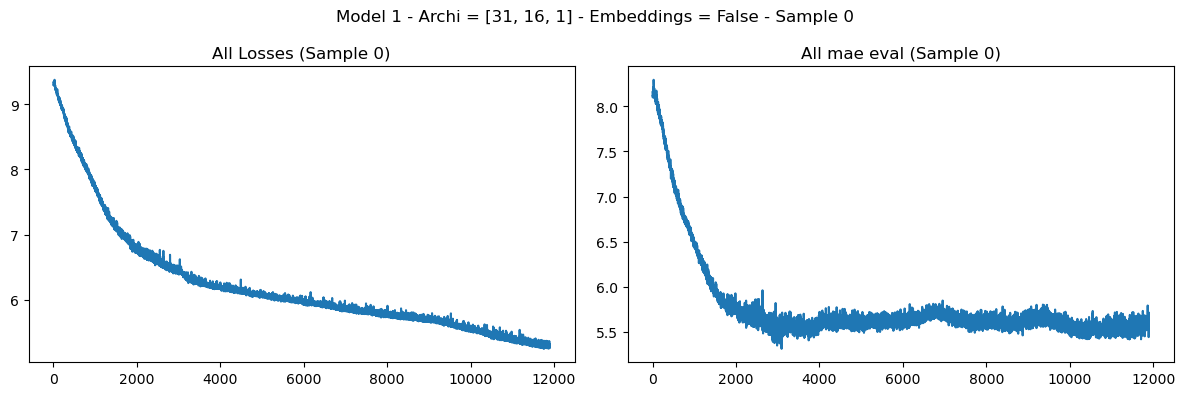

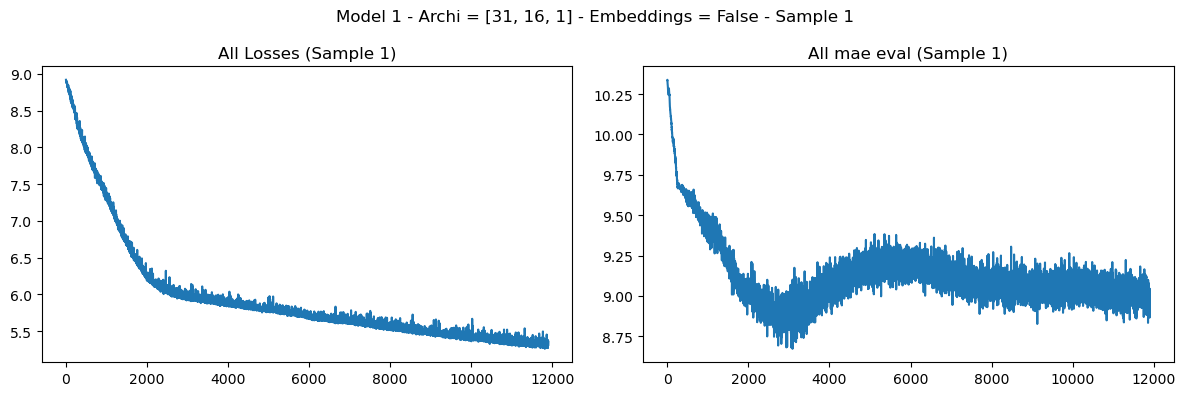

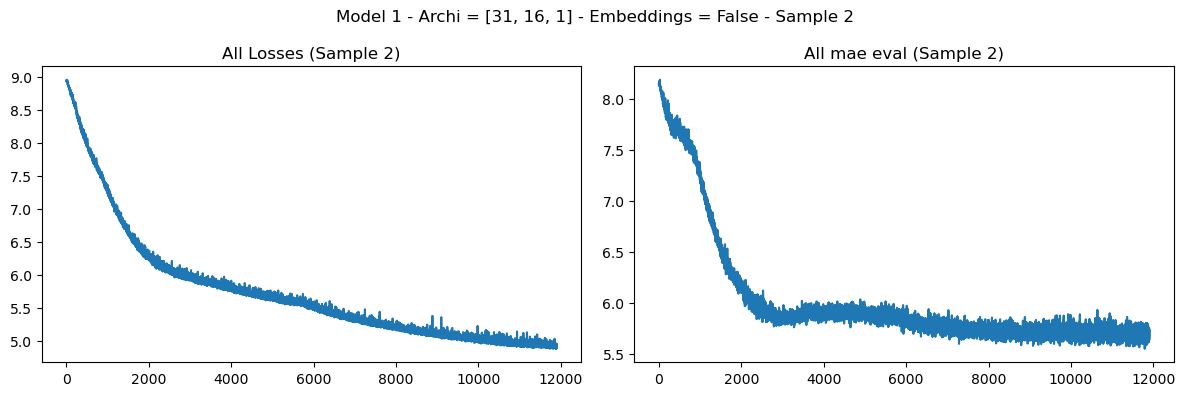

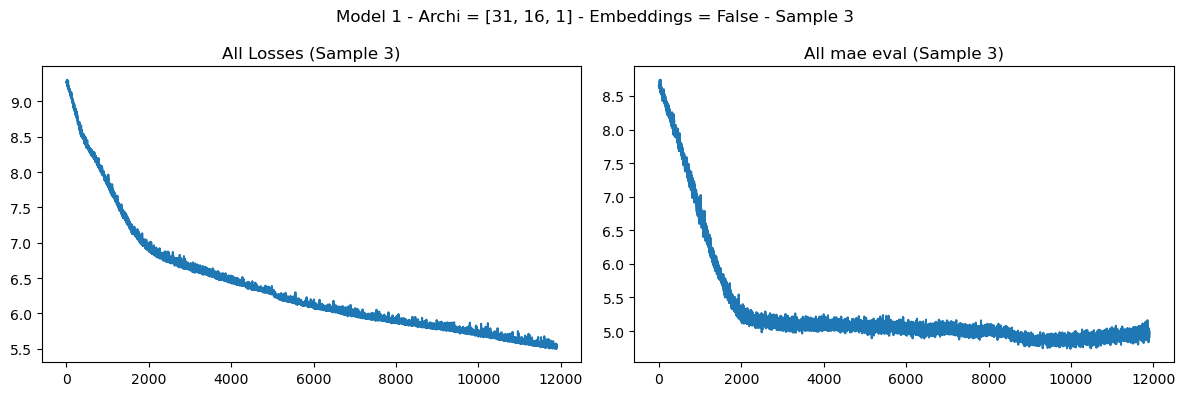

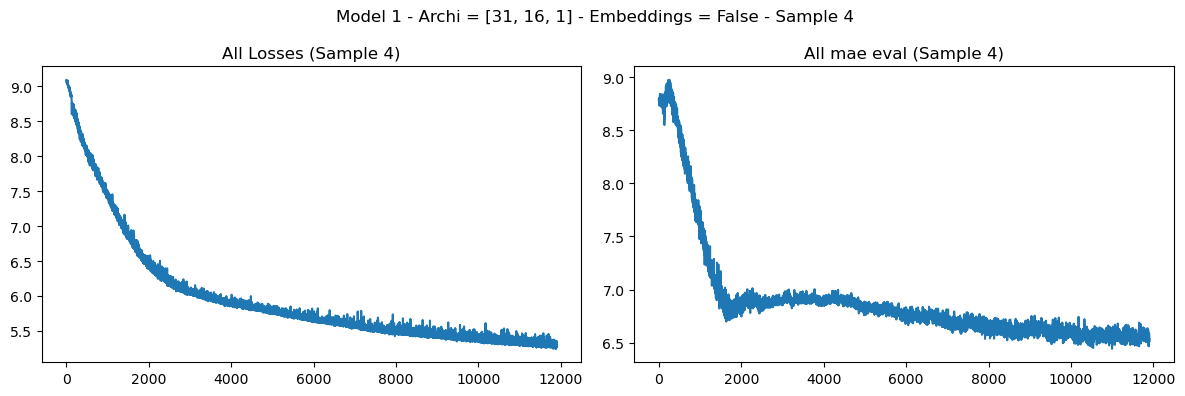

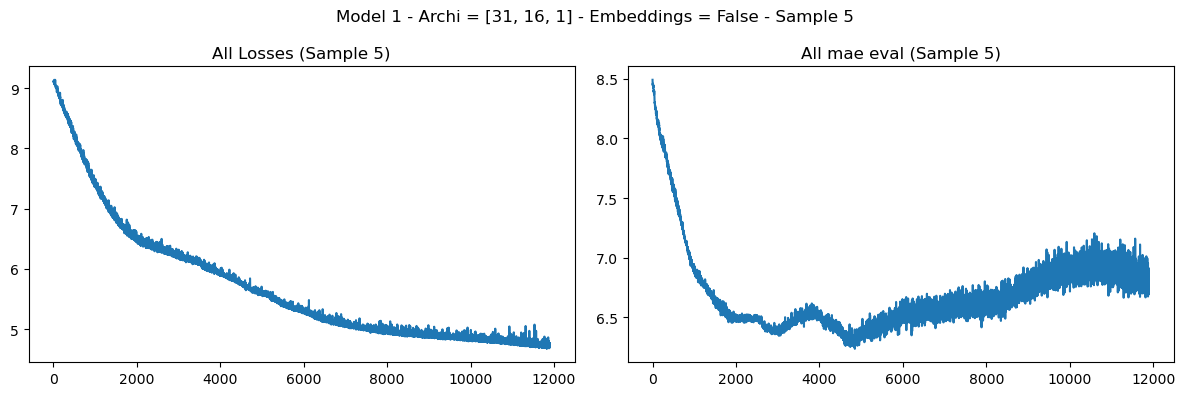

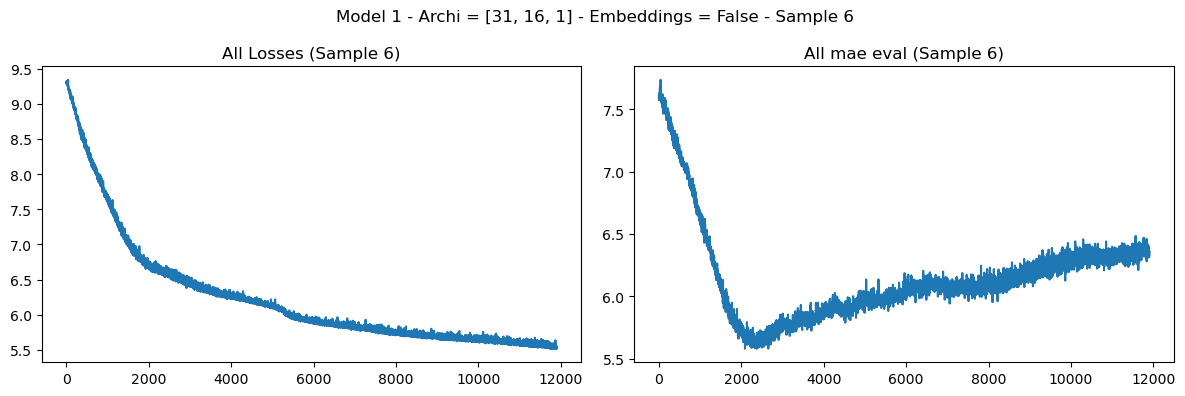

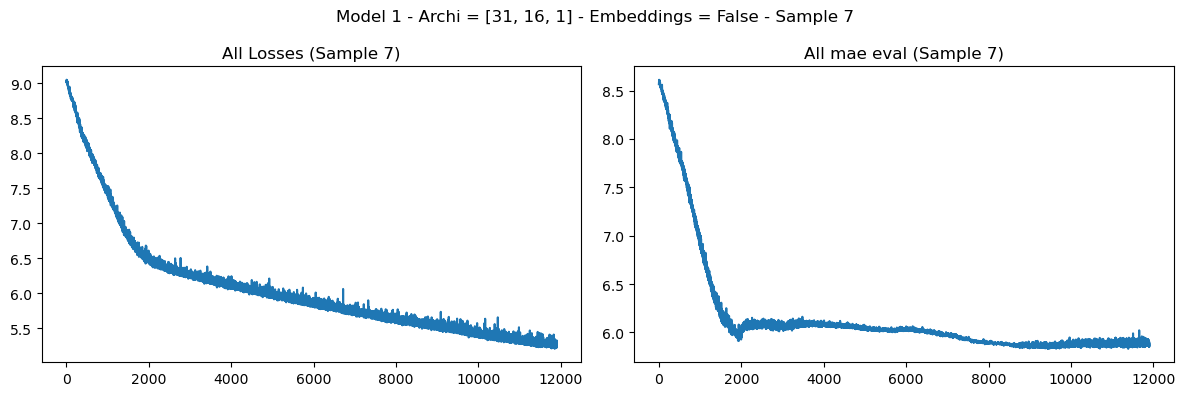

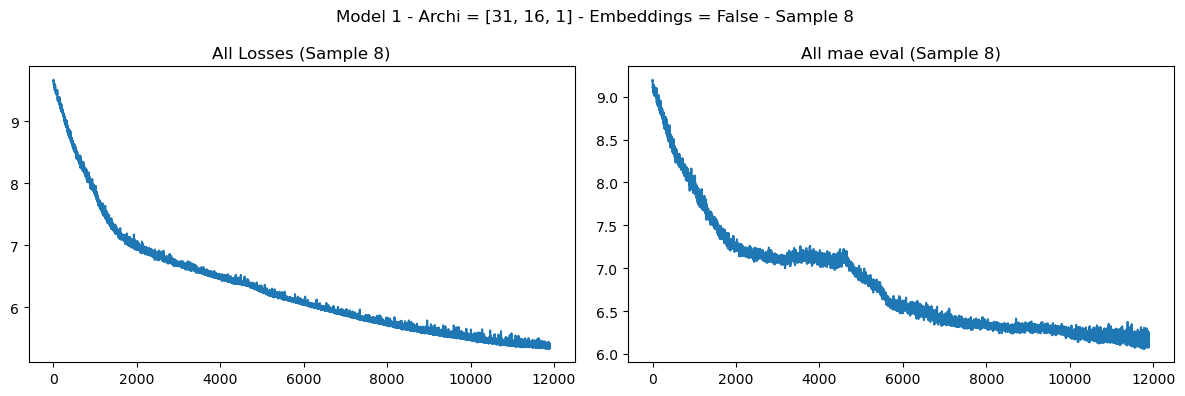

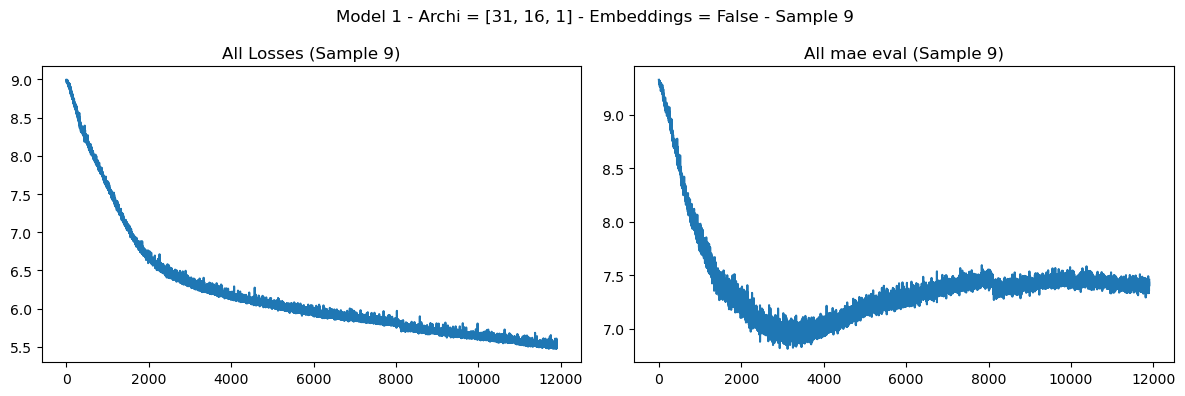

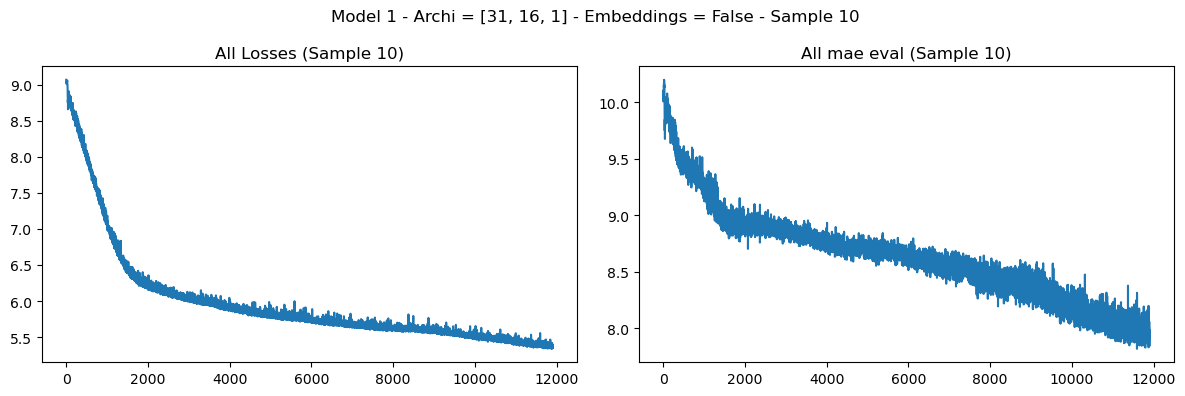

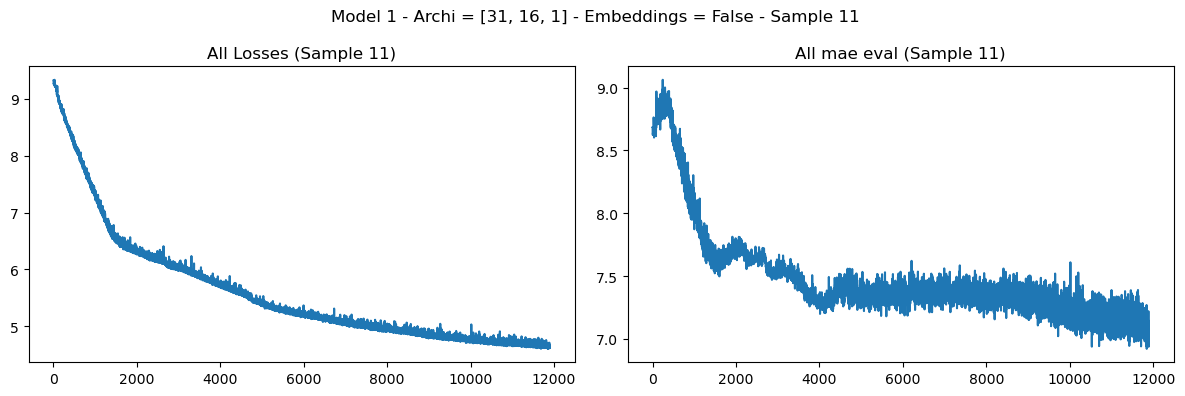

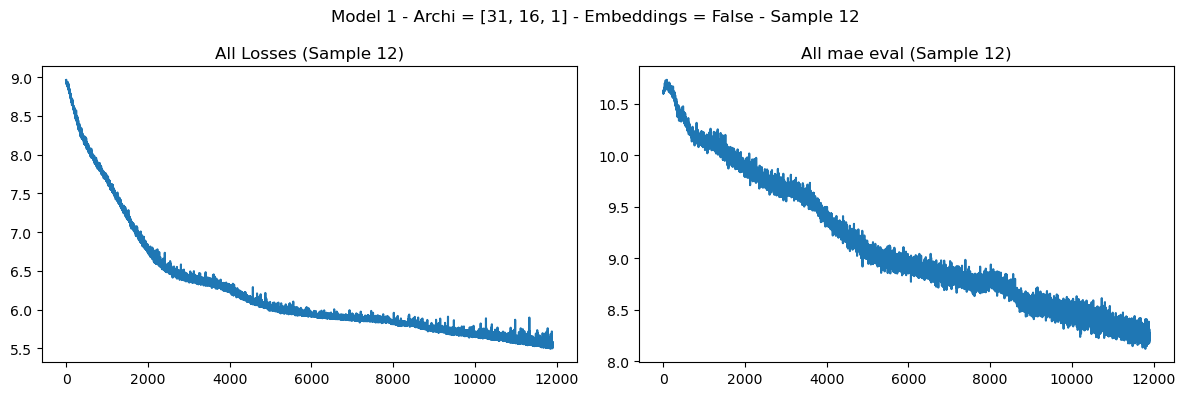

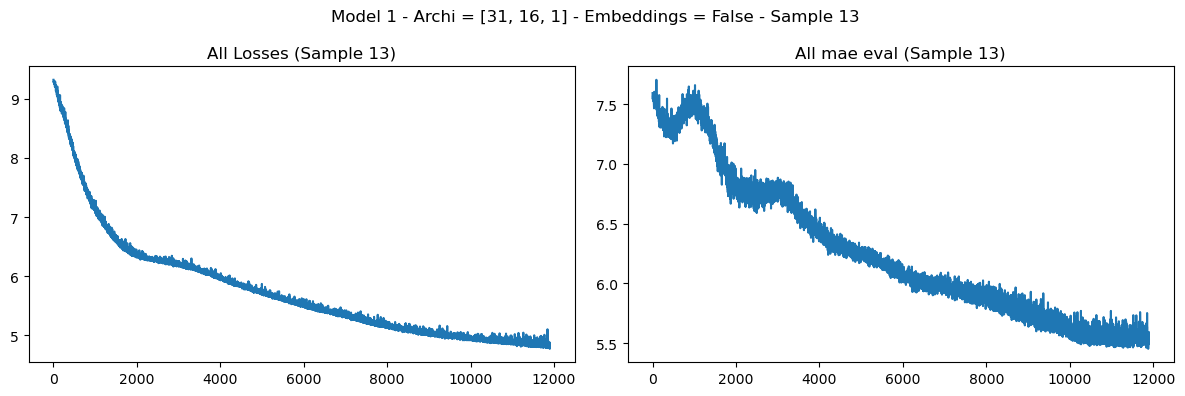

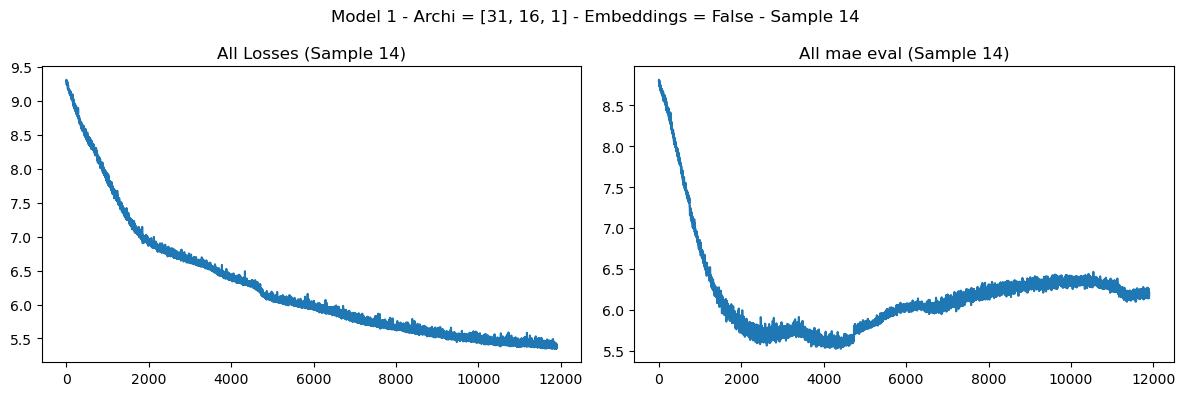

In [17]:
model_index = 1

for sample in range(15):

    with open(f'results/02_model_comparison/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_mae_eval = pickle.load(f)

    with open(f'results/02_model_comparison/all_losses/all_losses_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_losses = pickle.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

    axes[0].plot(all_losses[100:])
    axes[0].set_title(f'All Losses (Sample {sample})')

    axes[1].plot(all_mae_eval[100:])
    axes[1].set_title(f'All mae eval (Sample {sample})')

    plt.suptitle(f'Model {model_index} - Archi = {df_models["architecture"][model_index - 1]} - '
                 f'Embeddings = {df_models["with_embeddings"][model_index - 1]} - Sample {sample}')

    plt.tight_layout()

    plt.show()

In [18]:
model_index = 12

min_epochs = []

for sample in range(15):

    with open(f'results/02_model_comparison/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_mae_eval = pickle.load(f)

    min_epochs.append (all_mae_eval.index (min (all_mae_eval)))

min_epochs

[7935,
 9753,
 7275,
 10937,
 3013,
 9994,
 2416,
 2710,
 5136,
 11310,
 4202,
 2630,
 1926,
 496,
 8870]

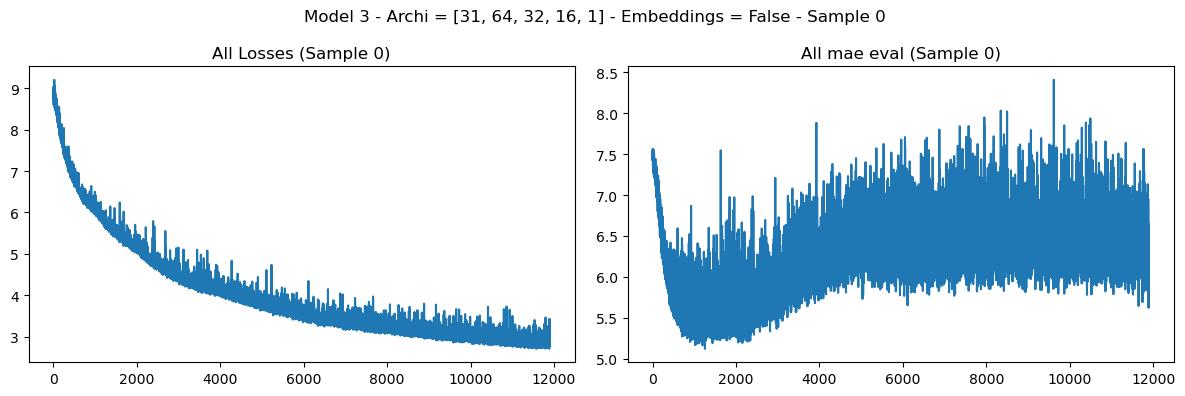

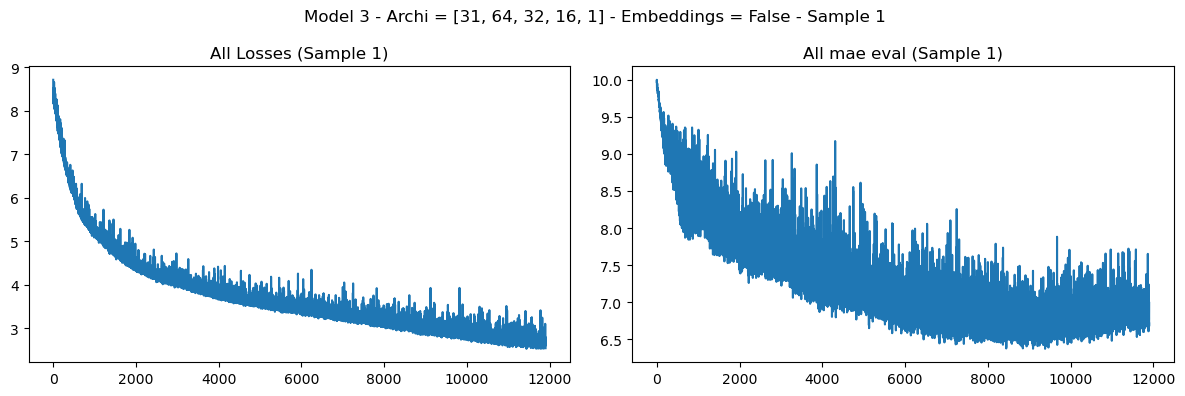

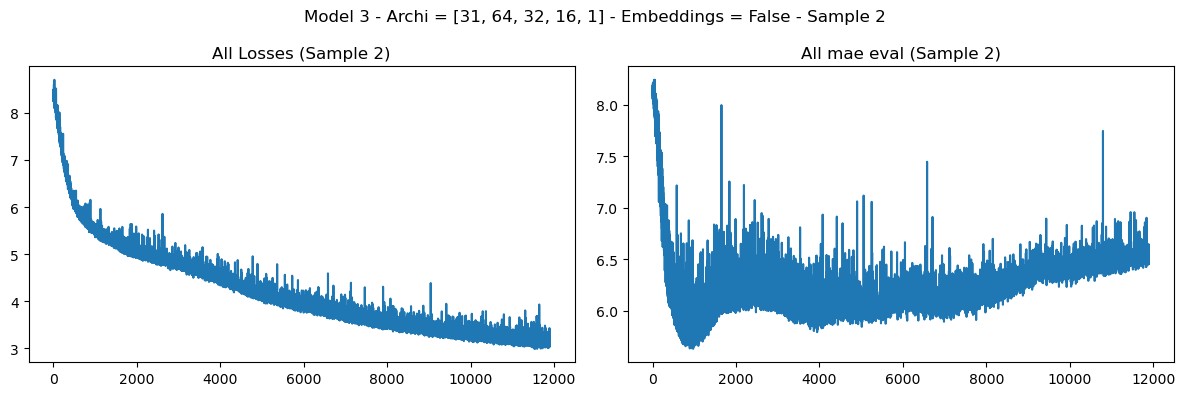

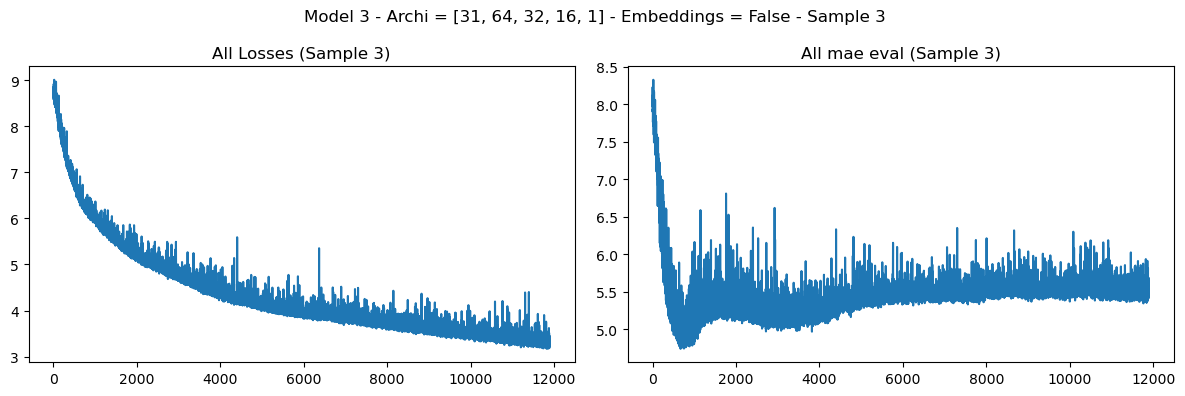

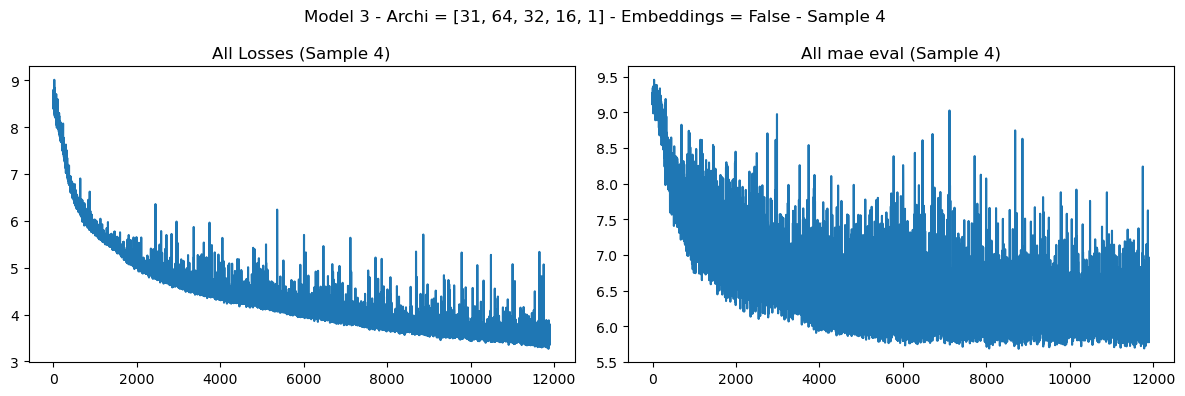

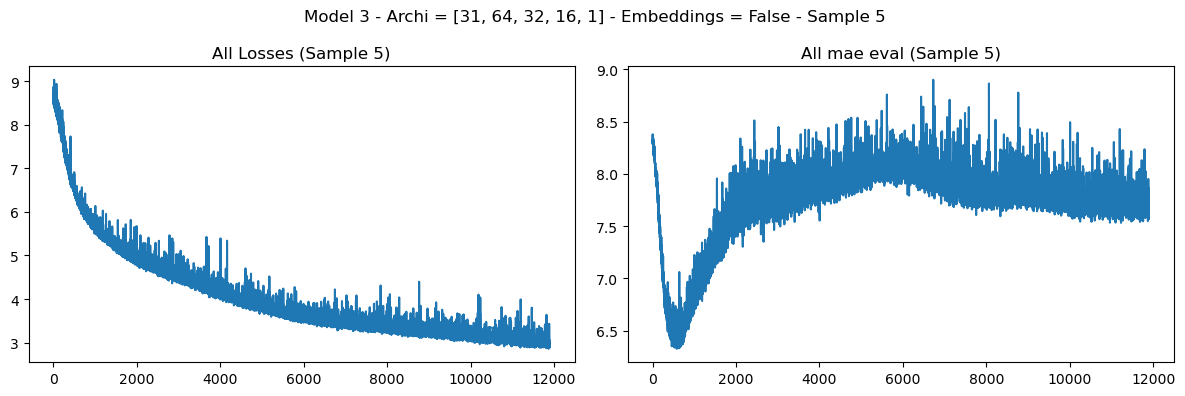

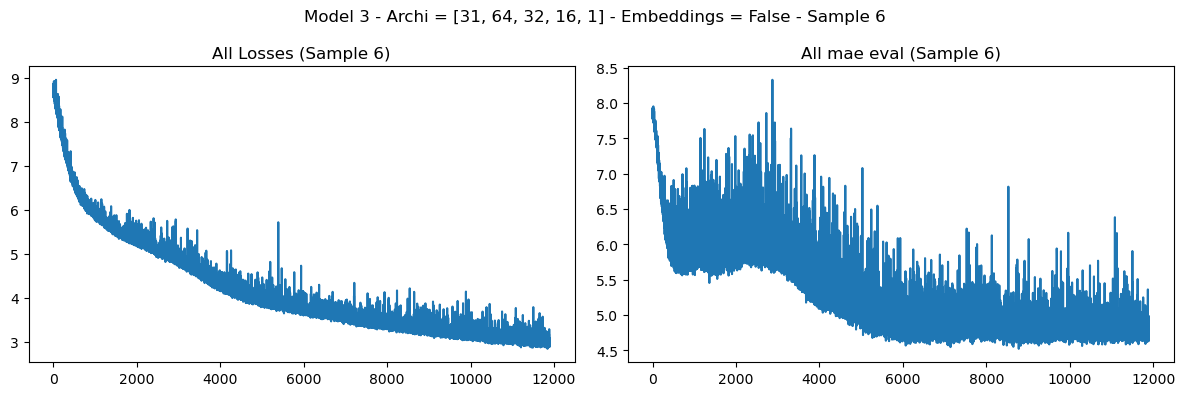

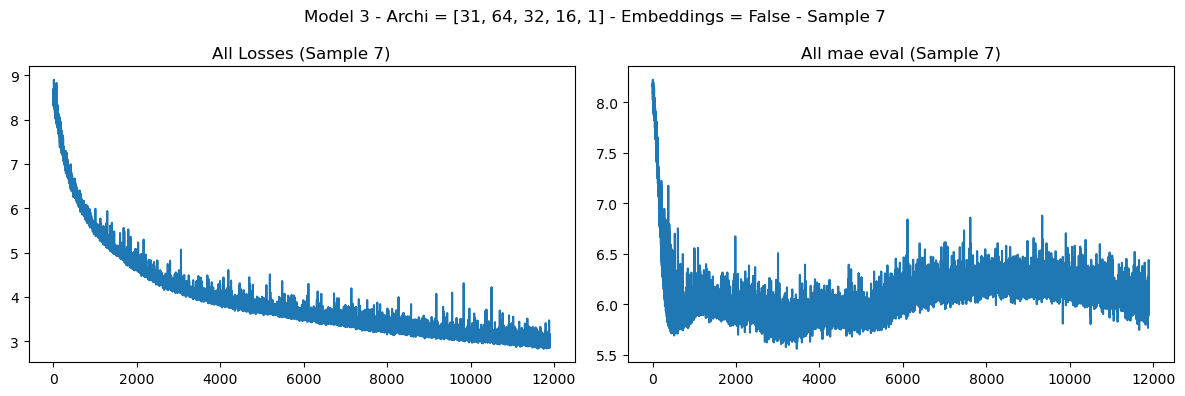

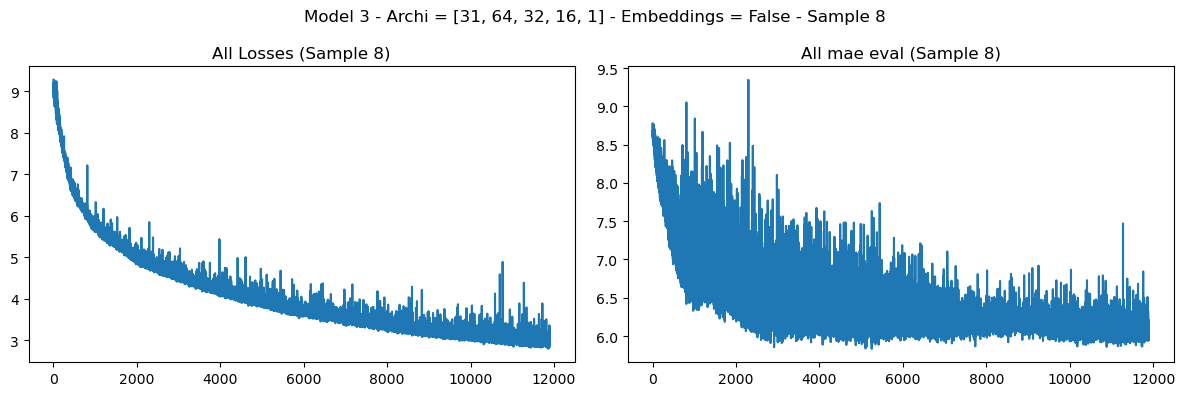

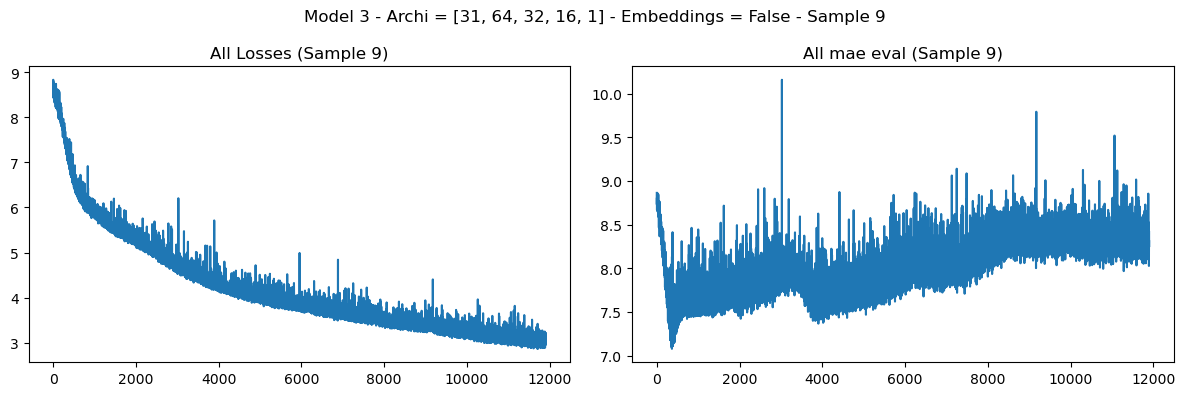

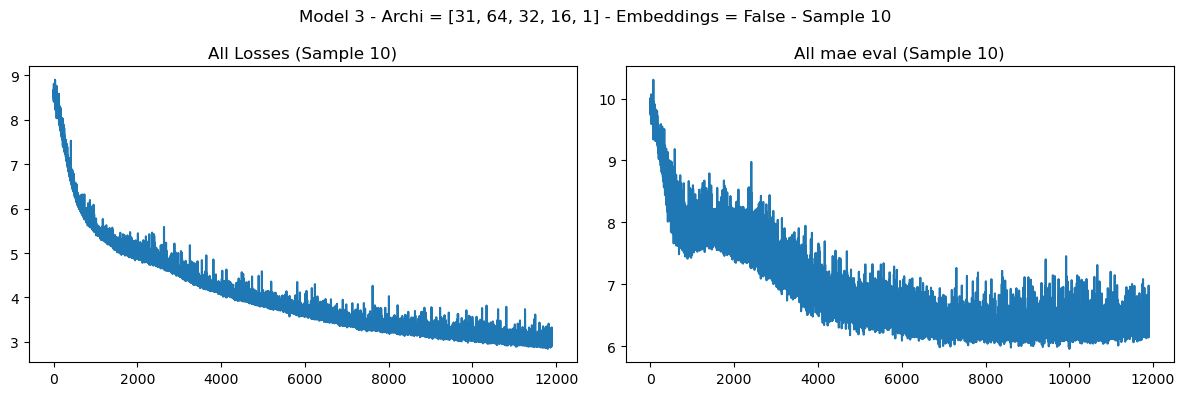

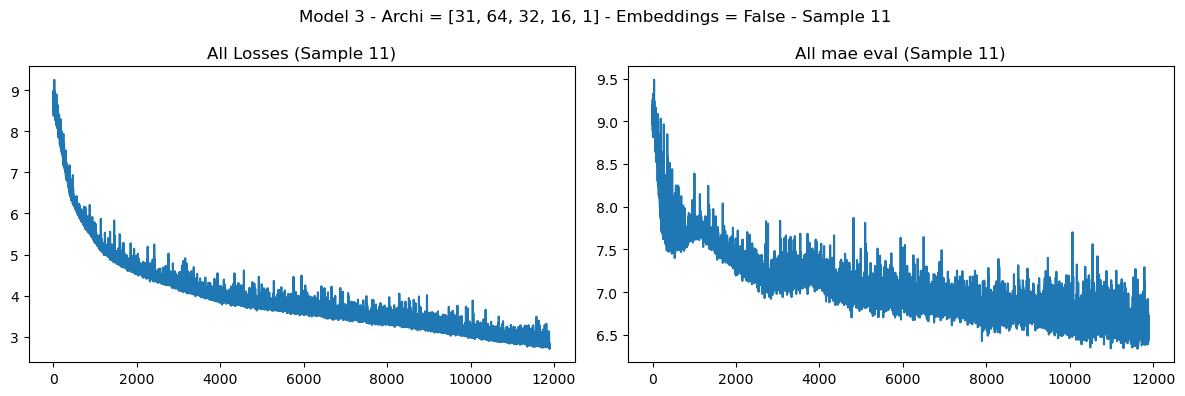

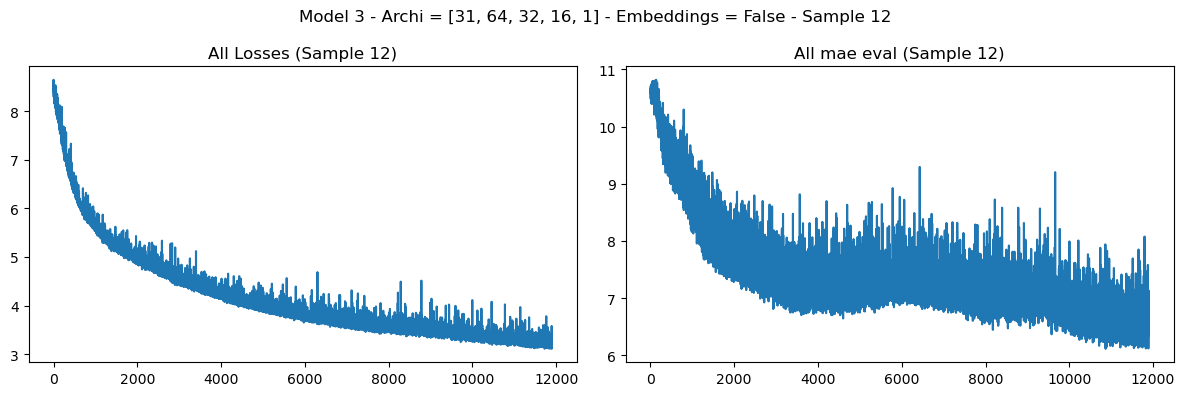

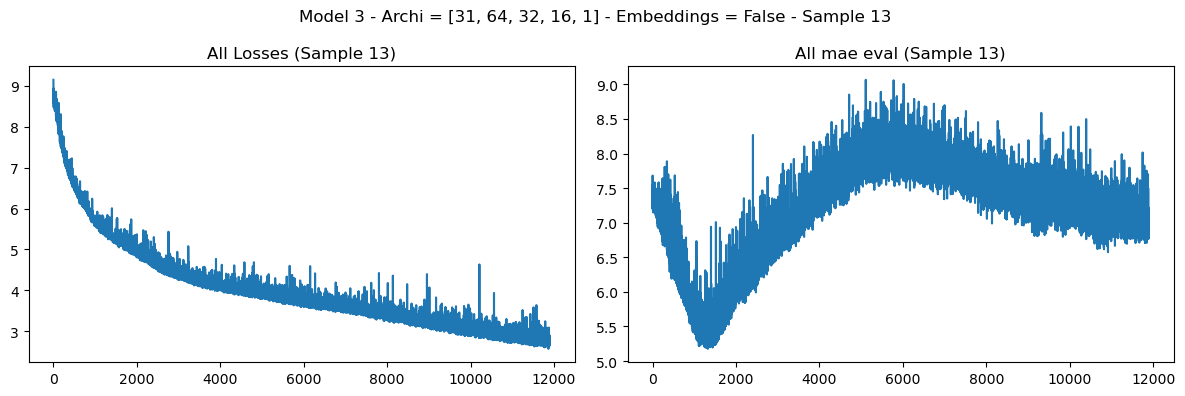

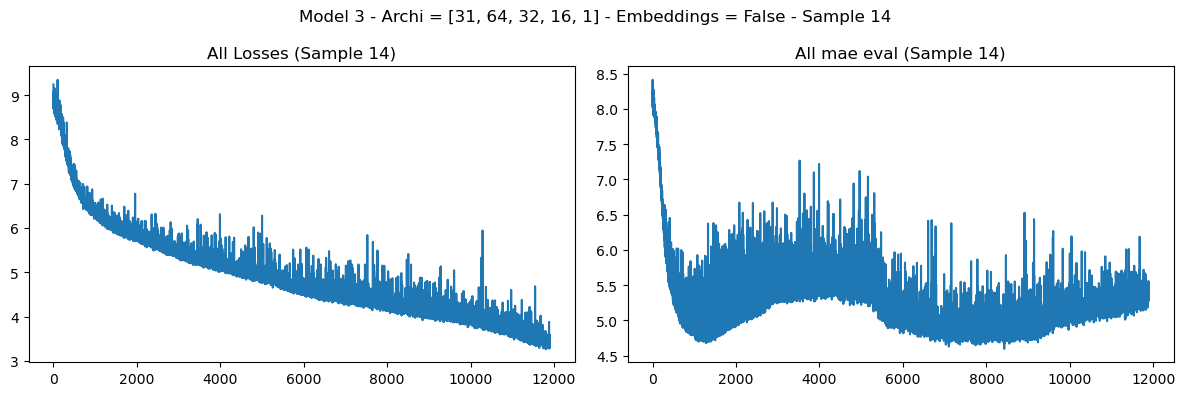

In [19]:
model_index = 3

for sample in range(15):

    with open(f'results/02_model_comparison/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_mae_eval = pickle.load(f)

    with open(f'results/02_model_comparison/all_losses/all_losses_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_losses = pickle.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

    axes[0].plot(all_losses[100:])
    axes[0].set_title(f'All Losses (Sample {sample})')

    axes[1].plot(all_mae_eval[100:])
    axes[1].set_title(f'All mae eval (Sample {sample})')

    plt.suptitle(f'Model {model_index} - Archi = {df_models["architecture"][model_index - 1]} - '
                 f'Embeddings = {df_models["with_embeddings"][model_index - 1]} - Sample {sample}')

    plt.tight_layout()

    plt.show()

In [20]:
folder_path = "results/02_model_comparison/df_res"

df_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):  
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)  
        df_list.append(df)

df_all_predictions = pd.concat(df_list, ignore_index=True)

In [21]:
df_all_predictions.shape

(13320, 7)

In [22]:
df_all_predictions.head(2)

,sample,model,pmid,e.cum,ct,prediction_ecum,running_time
0,4,9,184,12.965,164.15,5.175395,4.363279
1,4,9,205,30.425,168.50,9.853112,4.363279


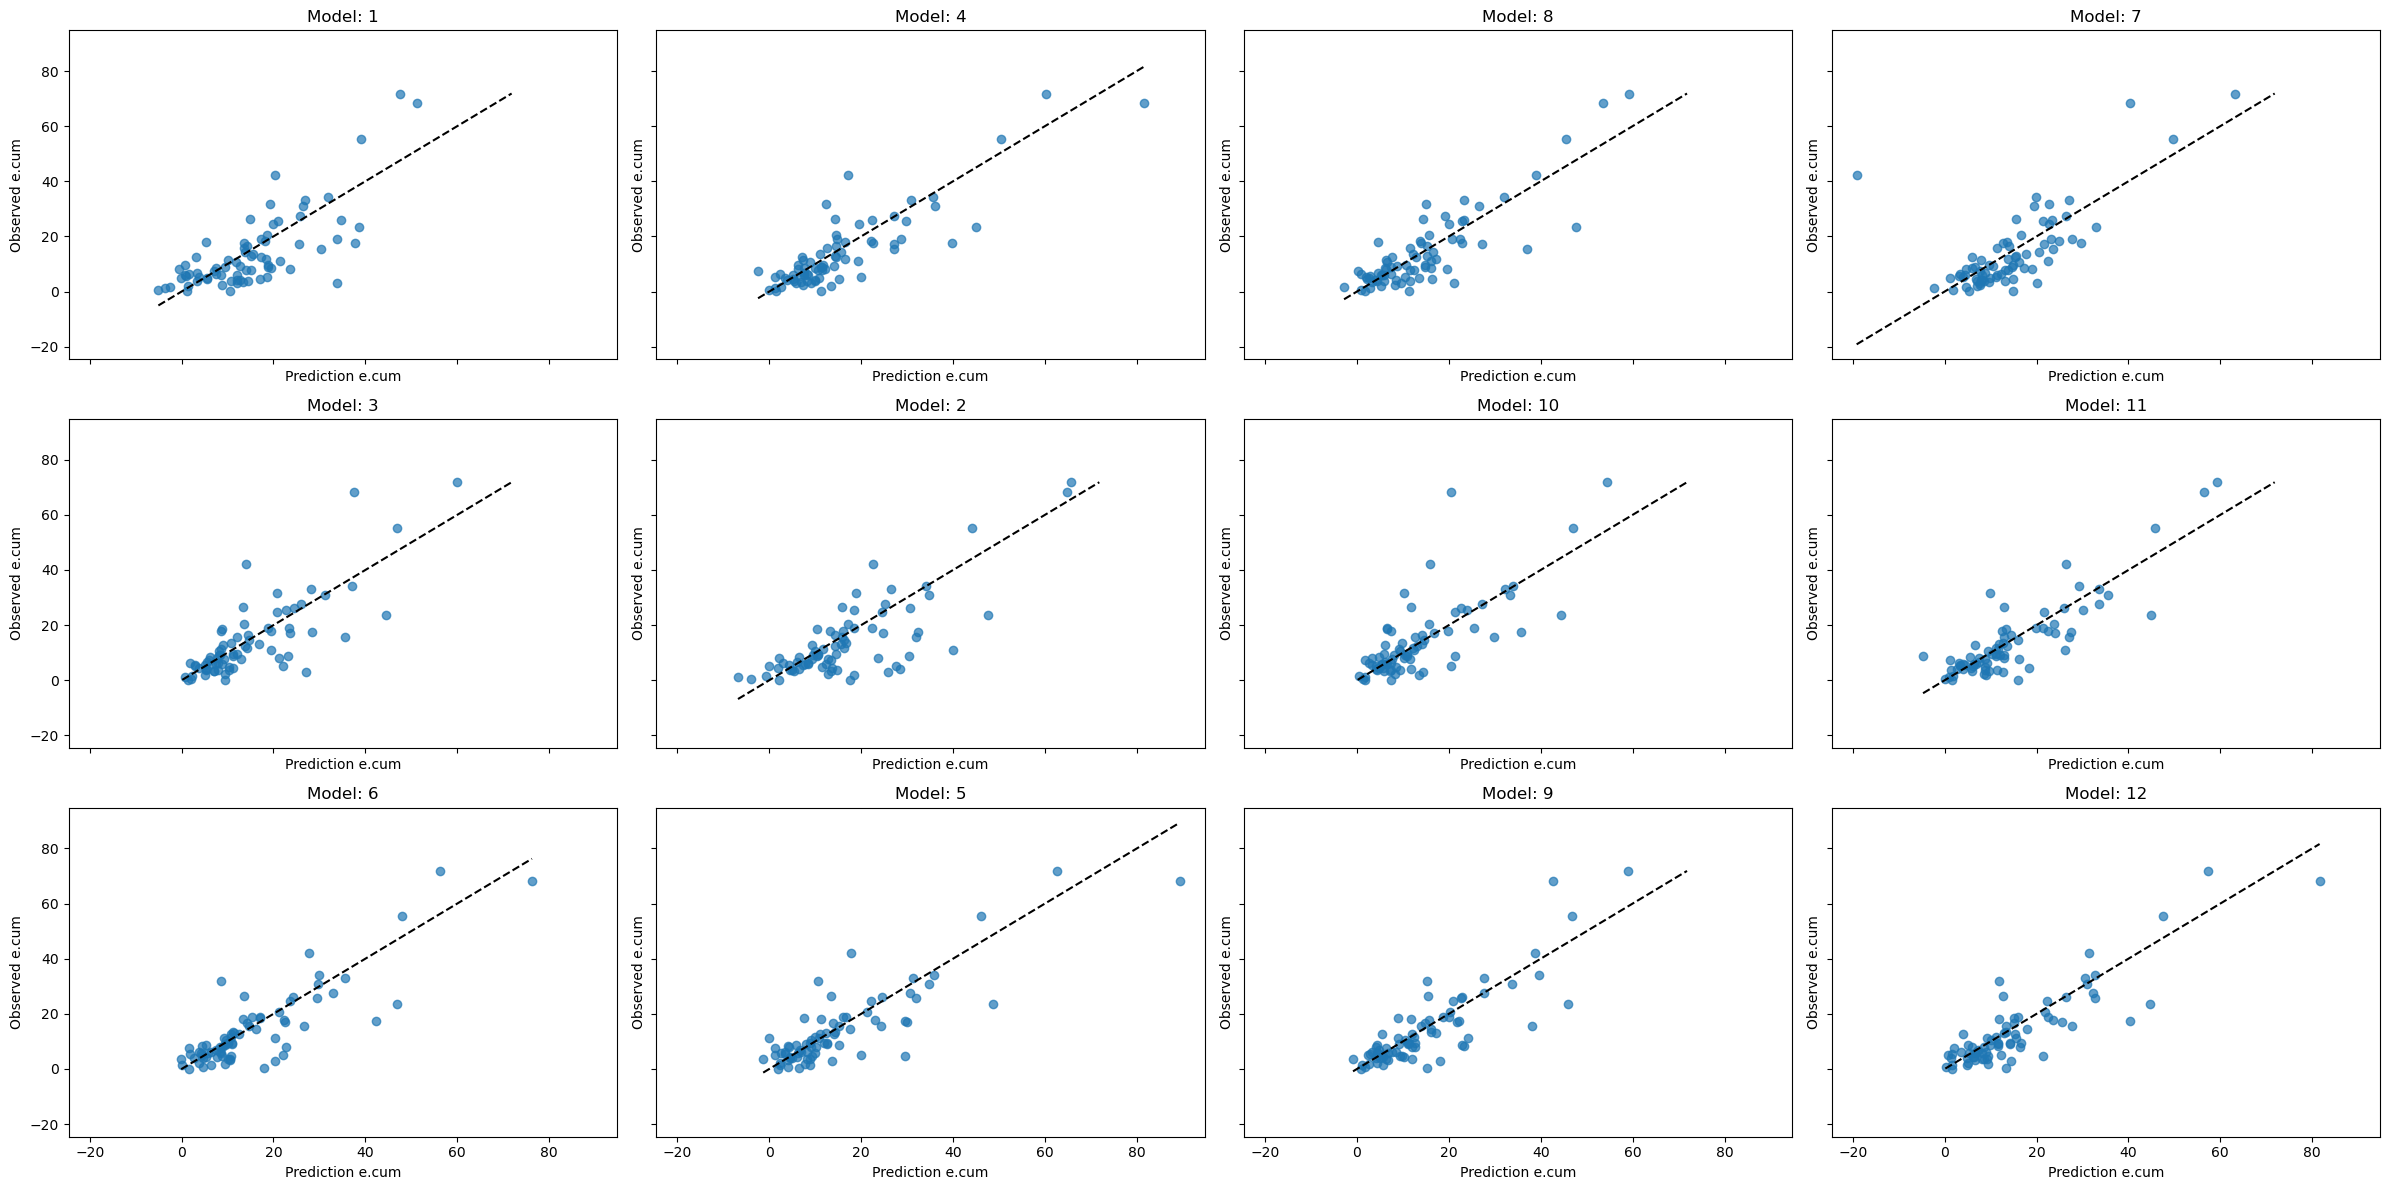

In [23]:
sample = 1

df_filtered = df_all_predictions[df_all_predictions["sample"] == 0]

models = df_filtered["model"].unique()

fig, axes = plt.subplots(nrows = 3, ncols=4, figsize=(2 * len(models), 12), sharex=True, sharey=True)

axes = axes.flatten()

for ax, model in zip(axes, models):
    df_model = df_filtered[df_filtered["model"] == model]
    ax.scatter(df_model["prediction_ecum"], df_model["e.cum"], alpha=0.7)

    # Tracer la ligne y = x
    min_val = min(df_model["prediction_ecum"].min(), df_model["e.cum"].min())
    max_val = max(df_model["prediction_ecum"].max(), df_model["e.cum"].max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black")

    ax.set_title(f"Model: {model}")
    ax.set_xlabel("Prediction e.cum")
    ax.set_ylabel("Observed e.cum")

plt.tight_layout()
plt.show()

In [24]:
df_all_predictions.head(2)

,sample,model,pmid,e.cum,ct,prediction_ecum,running_time
0,4,9,184,12.965,164.15,5.175395,4.363279
1,4,9,205,30.425,168.50,9.853112,4.363279


In [25]:
df_running_time = df_all_predictions.groupby(['sample', 'model'], as_index=False).agg({'running_time': 'first'})
df_running_time['running_time'].sum() / 60

12.397752417524655

In [26]:
df_mae = df_all_predictions.groupby(['sample', 'model'], as_index=False).agg(
    mae=('e.cum', lambda x: (x - df_all_predictions.loc[x.index, 'prediction_ecum']).abs().mean())
)

df_mae.head(2)

,sample,model,mae
0,0,1,7.226914
1,0,2,6.648374


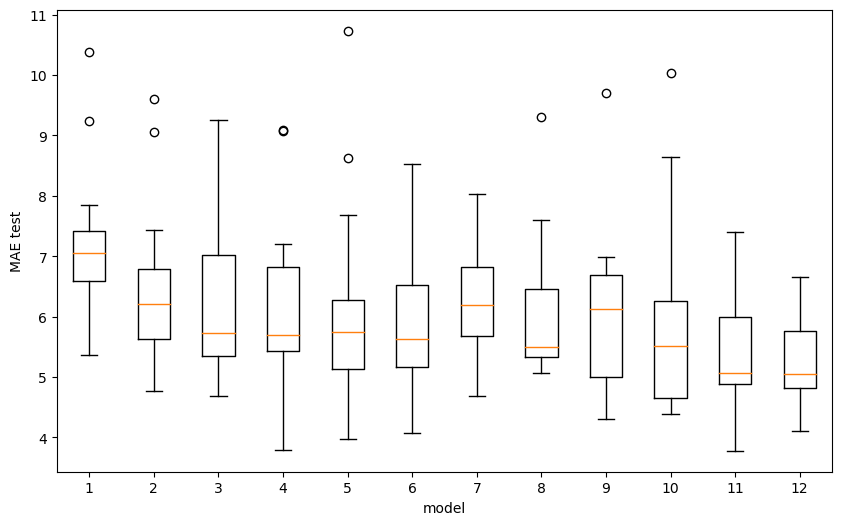

In [27]:
grouped_data = [df_mae[df_mae["model"] == m]["mae"]
                for m in sorted(df_mae["model"].unique())]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data, labels=sorted(df_mae["model"].unique()))  # Utiliser tick_labels au lieu de labels

plt.xlabel("model")
plt.ylabel("MAE test")

plt.show()

# End